# Capstone Project Code

## Load Packages

In [38]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import os
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
import tensorflow as tf
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore")
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Initial Exploration
- Load Data
- Explore Data Pattern
- Explore Missing Values


### Load Data

In [39]:
A01_17= pd.read_hdf('/content/drive/MyDrive/pressure_data/A01_CMPR_COMPRESSOR_SUPPLY_PRESSURE_20161231_366days.hdf')

In [40]:
W01 = pd.read_hdf('/content/drive/MyDrive/weather/WeatherStationController_MeteoCentral_TEMPERATURE_20161231_366days.hdf')

### Explore Data Pattern

In [41]:
def decompose_date_time(df):
  df['day'] = df['Date'].dt.day
  df['month'] = df['Date'].dt.month
  df['year'] = df['Date'].dt.year
  df['hour'] = df['Date'].dt.hour
  df['minute'] = df['Date'].dt.minute
  df['second'] = df['Date'].dt.second

In [42]:
ABS_PATH = '/content/drive/MyDrive/'

def read_and_merge_data(data_type):
  '''
  read_and_merge_data('weather') returns a dictionary that maps
    location to the weather data with columns 'Date' and 'Data'

  read_and_merge_data('pressure_data') returns a dictionary that maps
    location to the pressure data with columns 'Date' and 'Data'
  '''
  path = ABS_PATH + data_type
  os.chdir(path)
  filenames = os.listdir()
  filenames.sort()
  data_ret = {}
  # collect data of the same lcoation
  for i in range(len(filenames)//3):
    curr_files = filenames[i*3:i*3+3]
    if data_type == "weather":
      curr_loc = curr_files[0].split('_')[1]
    else:
      curr_loc = curr_files[0].split('_')[0]

    dfs = []
    for file in curr_files:
      file_path = f"{path}/{file}"
      df = pd.read_hdf(file_path)
      df.reset_index(inplace = True)
      mapping = {df.columns[0]:'Date', df.columns[1]: 'Data'}
      df = df.rename(columns=mapping)
      decompose_date_time(df)
      dfs.append(df)
    data_ret[curr_loc] = pd.concat(dfs)
  return data_ret

In [43]:
weather_data = read_and_merge_data("weather")
pressure_data = read_and_merge_data("pressure_data")

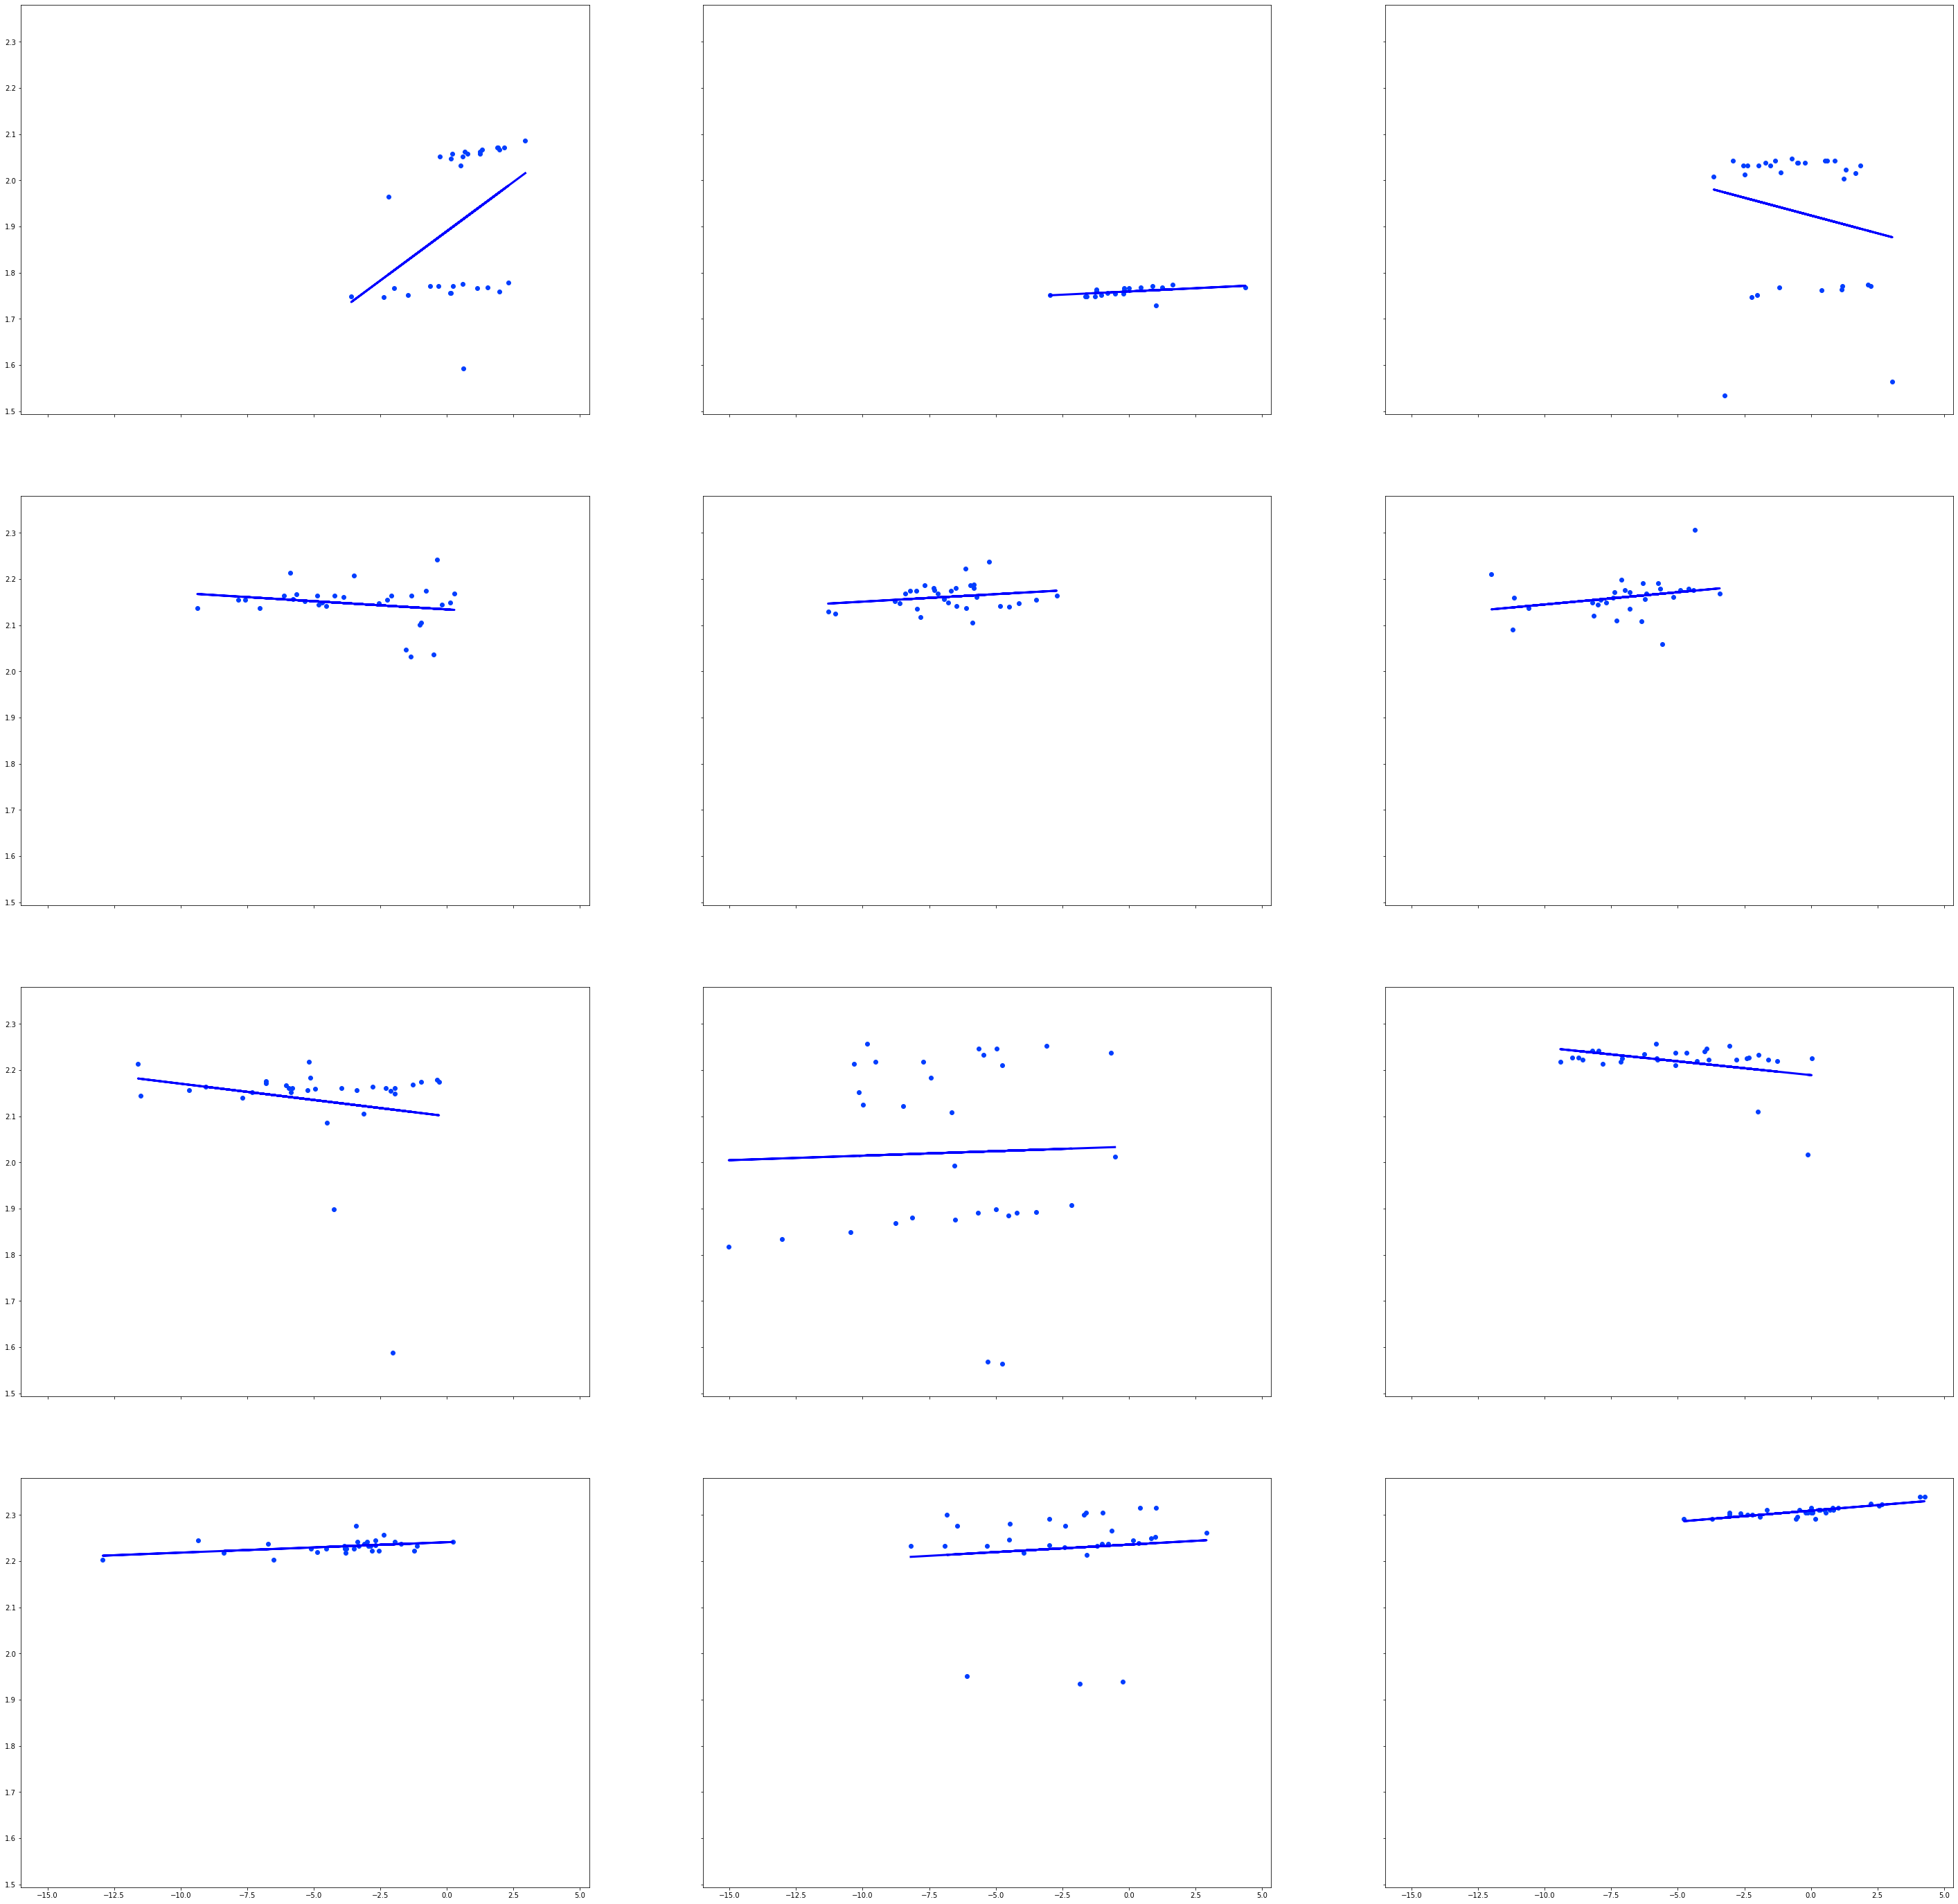

In [37]:
def scatter_day_data_in_year(pressure, weather, year):
  pressure_year_data = pressure[pressure['year'] == year]
  weather_year_data = weather[weather['year'] == year]
  fig, axes = plt.subplots(4, 3, figsize=(50, 50), sharex=True, sharey=True)
  r_2 = []
  MSE = []
  for month in range(1, 13):
    pressure_month_data = pressure_year_data[pressure_year_data['month'] == month][['day', 'Data']]
    weather_month_data = weather_year_data[weather_year_data['month'] == month][['day', 'Data']]
    # daily_min = month_data.groupby('day').min()
    # daily_max = month_data.groupby('day').max()
    # daily_median = month_data.groupby('day').median()
    pressure_daily_median = pressure_month_data.groupby('day').median()
    weather_daily_median = weather_month_data.groupby('day').median()
    pressure_daily_median = pressure_daily_median.rename(columns={"Data":"pressure"})
    weather_daily_median = weather_daily_median.rename(columns={"Data":"weather"})
    median_table = pd.concat([weather_daily_median, pressure_daily_median], axis=1)
    median_table = median_table.dropna()
    
    regr = linear_model.LinearRegression()
    regr.fit(median_table['weather'].to_numpy().reshape(-1,1), median_table['pressure'].to_numpy().reshape(-1,1))
    pressure_pred = regr.predict(median_table['weather'].to_numpy().reshape(-1,1))

    r_2.append(r2_score(median_table['pressure'].to_numpy().reshape(-1,1), pressure_pred))
    MSE.append(mean_squared_error(median_table['pressure'].to_numpy().reshape(-1,1), pressure_pred))

    axes[(month-1)//3, (month-1)%3].scatter(data=median_table, x='weather', y='pressure')
    axes[(month-1)//3, (month-1)%3].plot(median_table['weather'], pressure_pred, color="blue", linewidth=3)

  metrics = pd.DataFrame(list(zip(r_2, MSE)),columns =['r_squared', 'MSE'], \
                         index =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
  return metrics

metrics = scatter_day_data_in_year(pressure_data['A04'], weather_data['MeteoCentral'], 2017)
# weather_data['MeteoCentral']
